In [6]:
import string
import numpy as np
from pickle import load
from os.path import isfile

from pickle import dump
import matplotlib.pyplot as plt

import time

import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

from sklearn.utils import shuffle
from IPython.display import Image, display
from itertools import repeat

2022-12-21 17:39:43.914597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [8]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping


In [9]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

In [10]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [11]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [12]:
filename = '../dataset/Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


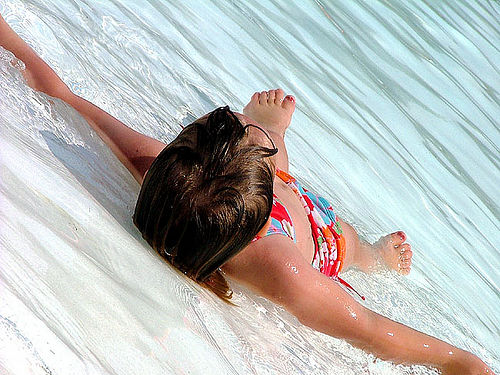

In [13]:
example_image = "../dataset/Flicker8k_Dataset/667626_18933d713e.jpg"
display(Image(example_image))

In [14]:
example_id = '667626_18933d713e'
descriptions[example_id]

['A girl is stretched out in shallow water',
 'A girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'A little girl in a red swimsuit is laying on her back in shallow water .',
 'A young girl is lying in the sand , while ocean water is surrounding her .',
 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [15]:
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Vocabulary Size: 8763


In [16]:
descriptions[example_id]

['girl is stretched out in shallow water',
 'girl wearing red and multicolored bikini is laying on her back in shallow water',
 'little girl in red swimsuit is laying on her back in shallow water',
 'young girl is lying in the sand while ocean water is surrounding her',
 'girl wearing bikini lying on her back in shallow pool of clear blue water']

In [17]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [18]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = ' ' + ' '.join(image_desc) + ' '
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [19]:
# load training dataset (6K)
filename = '../dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# one image name per caption
img_name_train = [x for item in train for x in repeat(item, 5)]
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Dataset: 6000
Descriptions: train=6000


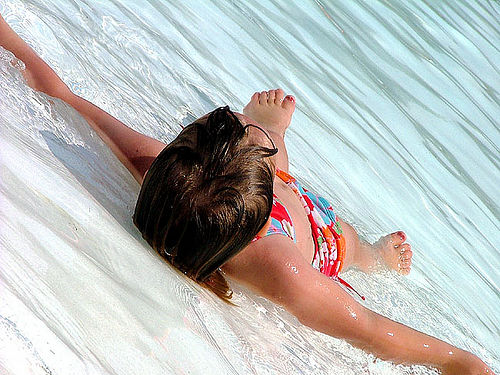

In [20]:
display(Image(example_image))

In [21]:
#  and  added
train_descriptions[example_id]

[' girl is stretched out in shallow water ',
 ' girl wearing red and multicolored bikini is laying on her back in shallow water ',
 ' little girl in red swimsuit is laying on her back in shallow water ',
 ' young girl is lying in the sand while ocean water is surrounding her ',
 ' girl wearing bikini lying on her back in shallow pool of clear blue water ']

In [22]:
# load val dataset
filename = '../dataset/Flickr8k_text/Flickr_8k.devImages.txt'
val = load_set(filename)
print('Dataset: %d' % len(val))
# one image name per caption
img_name_val = [x for item in val for x in repeat(item, 5)]
# descriptions
val_descriptions = load_clean_descriptions('descriptions.txt', val)
print('Descriptions: val=%d' % len(val_descriptions))

Dataset: 1000
Descriptions: val=1000


In [23]:
# load test set
filename = '../dataset/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# one image name per caption
img_name_test = [x for item in test for x in repeat(item, 5)]
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Dataset: 1000
Descriptions: test=1000


In [24]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [25]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions, top_k):
    lines = to_lines(descriptions)
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    tokenizer.fit_on_texts(lines)
    tokenizer.word_index[''] = 0
    tokenizer.index_word[0] = ''
    return tokenizer

In [26]:
# calculate the length of the description with the most words
def max_len(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)


In [27]:
def tokenize_captions(descriptions):
    caps_lists = list(descriptions.values())
    caps_list = [item for sublist in caps_lists for item in sublist]
    cap_seqs = tokenizer.texts_to_sequences(caps_list)
    cap_seqs = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')
    return cap_seqs

In [28]:
# prepare tokenizer
filename = 'tokenizer2.pkl'
# only create tokenizer if it does not exist
top_k = 5000
if not isfile(filename):
    tokenizer = create_tokenizer(train_descriptions, top_k)
    # save the tokenizer
    dump(tokenizer, open(filename, 'wb'))
else:
    tokenizer = load(open(filename, 'rb'))
# define vocabulary size
vocab_size = top_k + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_len(train_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 5001
Description Length: 32


In [29]:
# 10 most common words
list(tokenizer.word_index.items())[:10]

[('', 0),
 ('in', 2),
 ('the', 3),
 ('on', 4),
 ('is', 5),
 ('and', 6),
 ('dog', 7),
 ('with', 8),
 ('man', 9),
 ('of', 10)]

In [30]:
# 10 least common words
list(tokenizer.word_index.items())[-10:]

[('exotic', 7568),
 ('swatting', 7569),
 ('containig', 7570),
 ('rainstorm', 7571),
 ('breezeway', 7572),
 ('cocker', 7573),
 ('spaniels', 7574),
 ('majestically', 7575),
 ('scrolled', 7576),
 ('patterns', 7577)]

In [31]:
# tokenize captions
cap_train = tokenize_captions(train_descriptions)
cap_val = tokenize_captions(val_descriptions)
cap_test = tokenize_captions(test_descriptions)

In [32]:
def load_image(image_path):
    full_path = '../dataset/Flicker8k_Dataset/' + image_path + '.jpg'
    img = tf.io.read_file(full_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, image_path

In [33]:
def image_model():
    cnn_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    new_input = cnn_model.input
    hidden_layer = cnn_model.layers[-1].output

    model = tf.keras.Model(new_input, hidden_layer)
    model.summary()
    return model

In [ ]:
image_model = image_model()

In [ ]:
# union of all image names
img_name_vector = train | val | test
encode_images = sorted(set(img_name_vector))
# create dataset
image_dataset = tf.data.Dataset.from_tensor_slices(encode_images)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
for img, path in tqdm(image_dataset, position=0, leave=True):
    batch_features = image_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = '../dataset/features/' + p.numpy().decode("utf-8") + '.jpg'
        np.save(path_of_feature, bf.numpy())


In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # 
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)


    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
embedding_dim = 256
units = 512
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
features_shape = 512
attention_features_shape = 49

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load('../dataset/features/' + img_name.decode('utf-8') + '.jpg.npy')
    return img_tensor, cap

In [1]:
def create_dataset(img_name, cap):
    dataset = tf.data.Dataset.from_tensor_slices((img_name, cap))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [2]:
train_dataset = create_dataset(img_name_train, cap_train)
val_dataset = create_dataset(img_name_val, cap_val)

NameError: name 'img_name_train' is not defined

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden,_ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
@tf.function 
def val_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['']] * target.shape[0], 1)
    
    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))
    return loss, avg_loss

In [ ]:
EPOCHS = 10
loss_plot = []
val_loss_plot = []
best_val_loss = float("inf")
start_epoch = 0
num_steps_train = len(img_name_train) // BATCH_SIZE
num_steps_val = len(img_name_val) // BATCH_SIZE
start = time.time()

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    total_val_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(train_dataset), position=0, leave=True):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            loss = batch_loss.numpy() / int(target.shape[1])
            
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, loss))            
                    
    for (batch_val, (img_tensor_val, target_val)) in enumerate(val_dataset):
        batch_val_loss, t_val_loss = val_step(img_tensor_val, target_val)
        total_val_loss += t_val_loss

    # storing the epoch end loss value to plot later
    loss_mean = total_loss / num_steps_train
    loss_plot.append(loss_mean)
    # storing the epoch end val_loss value to plot later
    val_loss_mean = total_val_loss / num_steps_val
    val_loss_plot.append(val_loss_mean)
    
    print('Epoch {} Loss {:.6f} Val Loss {:.6f}'.format(epoch + 1, loss_mean, val_loss_mean))

    if val_loss_mean < best_val_loss:
        print('val_loss improved from %.4f to %.4f' % (best_val_loss, val_loss_mean))
        best_val_loss = val_loss_mean
        encoder.save_weights('../dataset/model_weights/cnn_encoder.h5')
        decoder.save_weights('../dataset/model_weights/rnn_decoder.h5')
    else:
        print('val_loss did not improve from %.4f' % (best_val_loss))

In [ ]:
plt.plot(loss_plot, label='loss')
plt.plot(val_loss_plot, label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def generate_desc(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['']], 0)
    result = ['']

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_weights.reshape(49,)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '':
            break

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    result = ' '.join(result)
    return result, attention_plot

In [ ]:
def generate_desc_beam_search(image, beam_index=3):
    start = [tokenizer.word_index['']]

    # result[0][0] = index of the starting word
    # result[0][1] = probability of the word predicted
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['']], 0)

    while len(result[0][0]) < max_length:
        i = 0
        temp = []
        for s in result:

            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i = i+1
            # Getting the top (n) predictions
            word_preds = np.argsort(predictions[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:       
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += predictions[0][w]
                temp.append([next_cap, prob])
        result = temp
        # Sorting according to the probabilities
        result = sorted(result, reverse=False, key=lambda l: l[1])
        # Getting the top words
        result = result[-beam_index:]

        # with Max Probability
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if prd_id != 3:
            # Decoder input is the word predicted with highest probability among the top_k words predicted
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break

    result = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result]
    final_caption = []
    for i in intermediate_caption:
        final_caption.append(i)
        if i == '':
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption)
    return final_caption, attention_plot

In [ ]:
def calculate_scores(actual, predicted):
    # calculate BLEU score
    smooth = SmoothingFunction().method4
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smooth)*100
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
    print('BLEU-1: %f' % bleu1)
    print('BLEU-2: %f' % bleu2)
    print('BLEU-3: %f' % bleu3)
    print('BLEU-4: %f' % bleu4)

In [ ]:
# evaluate the skill of the model
def evaluate_model():
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in tqdm(test_descriptions.items(), position=0, leave=True):
        # generate description
        yhat, _ = generate_desc(key)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('Sampling:')
    calculate_scores(actual, predicted)

In [ ]:
encoder.load_weights('../dataset/model_weights/cnn_encoder.h5')
decoder.load_weights('../dataset/model_weights/rnn_decoder.h5')

In [3]:
encoder.summary()
decoder.summary()

NameError: name 'encoder' is not defined

In [5]:
evaluate_model()

NameError: name 'evaluate_model' is not defined

In [ ]:
def evaluate_model2():
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in tqdm(test_descriptions.items(), position=0, leave=True):
        # generate description
        yhat, _ = generate_desc_beam_search(key)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('Sampling:')
    calculate_scores(actual, predicted)

In [ ]:
evaluate_model2()